In [52]:
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

df_daily = pd.read_gbq("select * from `intense-arbor-186802`.sample_data.top_3_prods",
                 project_id="intense-arbor-186802")

In [37]:
df_daily["resource_type"] = np.where(df_daily["resource_type"].str.contains("VCPU"),"VCPU",
         np.where(df_daily["resource_type"].str.contains("Fee"), "Licensing Fees",
                  np.where(df_daily["resource_type"].str.contains("GPU"), "GPU",
                           np.where(df_daily["resource_type"].str.contains("CPU"), "CPU",
#                                     np.where(df_daily["resource_type"].str.contains("Egress"), "Egress",
                                             np.where(df_daily["resource_type"].str.contains("PD"), "PD", 
                                                      np.where(df_daily["resource_type"].str.contains("Load Balancing"),"Load Balancing",
                                                              np.where(df_daily["resource_type"].str.contains("Custom instance"),"Custom Instance",
                                                                       np.where(df_daily["resource_type"].str.contains(" Regional Storage"),"Regional Storage",
                                                                               np.where(df_daily["resource_type"].str.contains("Multi-Regional Storage"),"Multi-Regional Storage",
                                                                                       np.where(df_daily["resource_type"].str.contains("Static Ip"), "Static Ip Charge",
                                                                                               df_daily["resource_type"]
                                                                                               )
                                                                                       )
                                                                               )
                                                                      )
                                                              )
                                                    )
#                                                )
                                      )
                            )
                    )
                                    )
                                             
                      
df_daily["resource_type"] = np.where((df_daily["resource_type"] == "Regional Storage US")|
                                     (df_daily["resource_type"] == "Regional Storage Asia"),
                                     "Regional Storage",
                                     df_daily["resource_type"])

In [53]:
# df_daily = df_daily[(df_daily["resource_type"] != "Custom Instance")]
# df_daily = df_daily[(df_daily["resource_type"] != "GPU")]
df_daily["resource_type"].unique()

array(['Analysis', 'Vpn Tunnel', 'Storage Image', 'Active Storage',
       'Static Ip Charge', 'Streaming Insert', 'Long Term Storage',
       'Regional Storage US', 'Storage PD Capacity',
       'Storage PD Snapshot', 'Regional Storage Asia',
       'SSD backed PD Capacity', 'Multi-Regional Storage US',
       'Network Inter Zone Egress', 'Storage PD Capacity in Japan',
       'Static Ip Charge in Singapore', 'Storage PD Capacity in Sydney',
       'SSD backed PD Capacity in Japan',
       'Storage PD Capacity in Virginia',
       'Class A Request Regional Storage',
       'SSD backed PD Capacity in Sydney',
       'Storage PD Capacity in Singapore',
       'Micro instance with burstable CPU',
       'SSD backed PD Capacity in Singapore',
       'Class A Request Multi-Regional Storage',
       'Custom instance Ram running in Americas',
       'Highmem Intel N1 2 VCPU running in APAC',
       'Custom instance Core running in Americas',
       'Highmem Intel N1 16 VCPU running in APAC',

In [39]:
df_daily["resource_type"] = np.where(df_daily["resource_type"].str.contains("Americas to Americas"), "Egress Americas to Americas",
         np.where((df_daily["resource_type"].str.contains("Sydney to Sydney")) | 
                  (df_daily["resource_type"].str.contains('Network Inter Zone Egress')),"Inter-zone Egress",
                  np.where(df_daily["resource_type"].str.contains("Americas to "),"Egress from Americas to Other",df_daily["resource_type"]
                          )
                 )
        )
df_daily["resource_type"].unique()

array(['Analysis', 'Vpn Tunnel', 'Storage Image', 'Active Storage',
       'Static Ip Charge', 'Streaming Insert', 'Long Term Storage',
       'Regional Storage', 'PD', 'Multi-Regional Storage',
       'Inter-zone Egress', 'CPU', 'VCPU',
       'Egress from Americas to Other', 'Egress Americas to Americas',
       'Licensing Fees', 'Load Balancing'], dtype=object)

In [40]:
df_daily.columns

Index(['start_time', 'product', 'unit', 'resource_type', 'cost',
       'usage_amount'],
      dtype='object')

In [44]:
df_daily = df_daily.groupby(['start_time','product','resource_type','unit']).sum().reset_index()

In [45]:
def plot_prod(product, legend=True):
    df_daily_prod = df_daily[df_daily["product"] == product][["start_time","unit","cost","resource_type"]]

    units_available = list(df_daily_prod["unit"].unique())
    print(f"Units available:{units_available}")
    unit = input("Enter unit: ") 

    df_daily_prod_unit = df_daily_prod[df_daily_prod["unit"] ==unit]
    df_daily_prod_unit_pivot = pd.pivot_table(df_daily_prod_unit, 
                                         values="cost", 
                                         index="start_time", 
                                         columns=["unit","resource_type"])

    for col in df_daily_prod_unit_pivot.columns:
        df_daily_prod_unit_pivot[col] = np.log(df_daily_prod_unit_pivot[col])

    df_daily_prod_unit_pivot.plot(title=product,figsize=(15,10),legend = legend)

## BigQuery Cost in Bytes

BigQuery costs in bytes are often consumed for either Analysis Queries(blue) or Streaming Inserts(orange). Examples of Analysis Queries include SQL queries, scripts, UDFs and other functions that can be exercised on BQ tables. Streaming Inserts figures track the cost involved in streaming data directly into BigQuery instead of using traditional batch updates. As expected, Streaming Inserts are more expensive ($0.01 per 200 MB) compared to batch uploads which are free when slot pricing is used.
https://cloud.google.com/bigquery/pricing#overview_of_pricing
https://cloud.google.com/bigquery/pricing#data_ingestion_pricing
https://cloud.google.com/bigquery/pricing#analysis_pricing_models

In the graph below, while Analysis Queries are fairly stable over the 7 month window, Streaming Insert costs have spiked early in the year and have risen in a step-wise fashion. The steps are clear during the beginning of 2017-06 with another escalation during the mid of 2017-07. 

Units available:['byte-seconds', 'bytes']
Enter unit: bytes


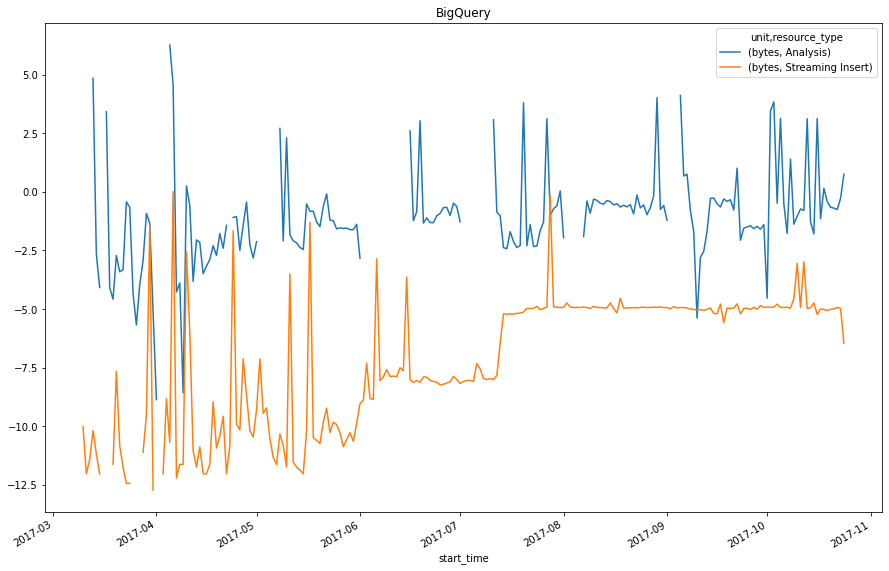

In [46]:
plot_prod("BigQuery")

## BigQuery Cost in Byte-Seconds

BigQuery costs in byte-seconds are measured for storage. Two types of storage are recorded in the billing data: Active Storage(blue) and Long Term Store(Orange). Active storage involves tables that have been updated for 90 days prior to storage classification. Long-term storage involves tables that has not been modified for 90 consecutive days. The price of storage is halved for tables that transition from Active to Long Term Storage. https://cloud.google.com/bigquery/pricing#storage

From the graph below, we can see that the Long Term Storage lines have breaks showing periods of time when teams retire datasets that are no longer in use. The transition of tables from Active to Long Term Storage is also visibile in the first couple of months in the graph. While the Active Storage tables grow and remain undeleted, we see the peak for the costs rise at the end of the 90 day period (at about April-mid). Once the 90 day timeline hits, the Active costs go down due to the halving while Long Term costs rise from April-mid till end of May. Similar patterns later in the year become difficult to generalize since byte-seconds later in the year don't register the generation of new tables or deletion of old ones.

Units available:['byte-seconds', 'bytes']
Enter unit: byte-seconds


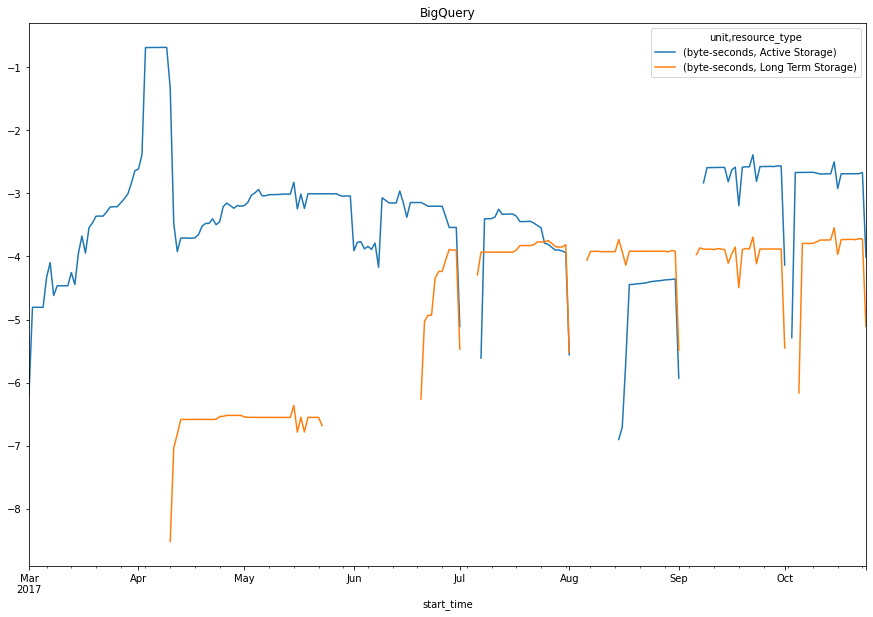

In [47]:
plot_prod("BigQuery")

## Cloud Storage Cost in Byte-Seconds

The Regional(orange) and Multi-Regional Storage(blue) measurements capture what fraction of GCS costs are incurred due to location. It costs more to store data in multiple regions; while availability is higher and latency is lower for apps deployed in these regions, the storage is more expensive. https://cloud.google.com/storage/docs/locations

In the graph below, we see higher use of regional storage (likely for testing in 1 region before multi-region rollout of apps), these costs plummet at the end where Multi-regional storage is likely leveraged for later deployments.

Units available:['byte-seconds', 'requests']
Enter unit: byte-seconds


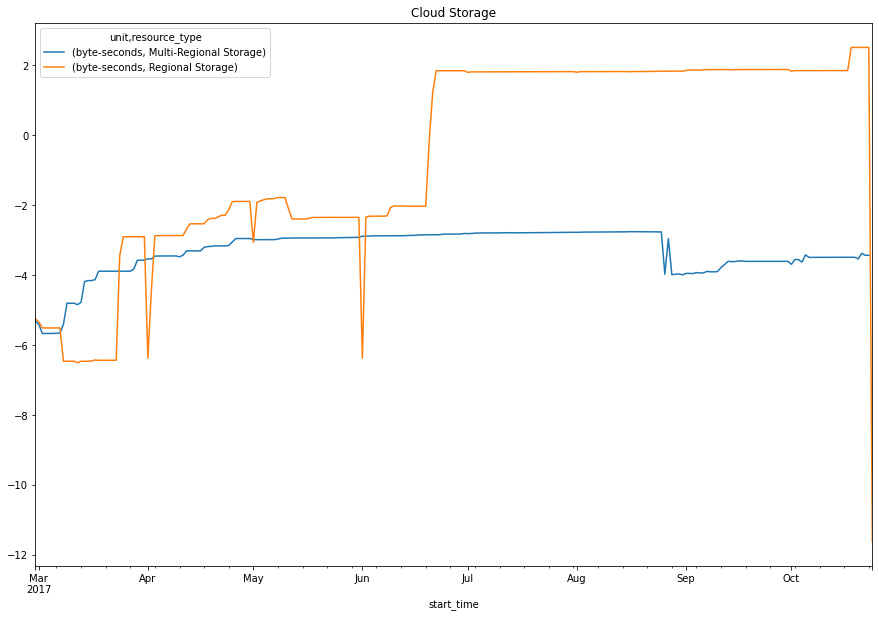

In [48]:
plot_prod("Cloud Storage")

## Google Compute Costs in Seconds


The Google Compute costs recorded as seconds mainly fall into the following categories:

1. CPU and vCPU - The most straightforward source of costs for a given VM. vCPU's tend to be more expensive than CPU's since they're more powerful. The machine type also heavily influences costs with general-type E2 machines costing less than memory-optimized M1 or M2 machines. The data does not record the type of machines that were spun to incur these costs but the usage is heavily vCPU driven according to the graph.https://cloud.google.com/compute/vm-instance-pricing

2. Licensing Fees - These are fees required to license images of SQL and other propriety products on spun up machines. https://cloud.google.com/compute/disks-image-pricing

3. VPN Tunnel - Google Cloud VPN's costs apply when the API is used for certain egress traffic.https://cloud.google.com/vpc/network-pricing#vpn-pricing

4. Load Balancing - Automatic load balancing of compute w.r.t traffic and load incurs these costs. We see a break in load balancing costs by the end of August 2017. This coincides with a significant dip in CPU/vCPU/Licensing costs. Some investigation into whether there was an outage of VMs during that time would be helpful. https://cloud.google.com/vpc/network-pricing#lb

5. Static IP Charge - Static IP addresses are charged as per details here. https://cloud.google.com/vpc/network-pricing#ipaddress
    

Units available:['seconds', 'bytes', 'byte-seconds']
Enter unit: seconds


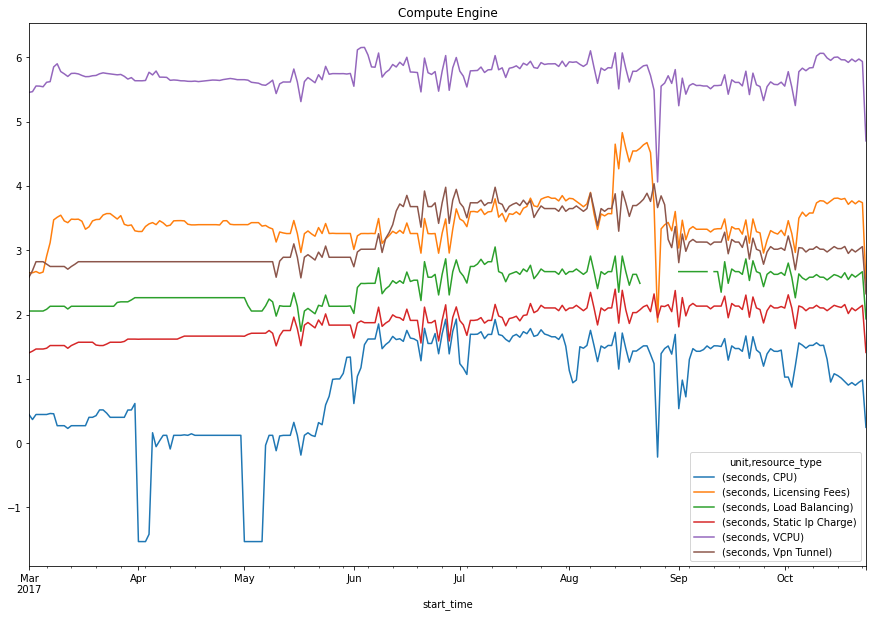

In [49]:
plot_prod("Compute Engine")

## Compute Engine Costs in Byte-Seconds

In byte-seconds, the costs accrued are recorded under persistent-disk (PD) fees and Storage Image fees. 

Persistent Disk fees  - https://cloud.google.com/compute/docs/disks#introduction
Storage Image - https://cloud.google.com/compute/disks-image-pricing

Units available:['seconds', 'bytes', 'byte-seconds']
Enter unit: byte-seconds


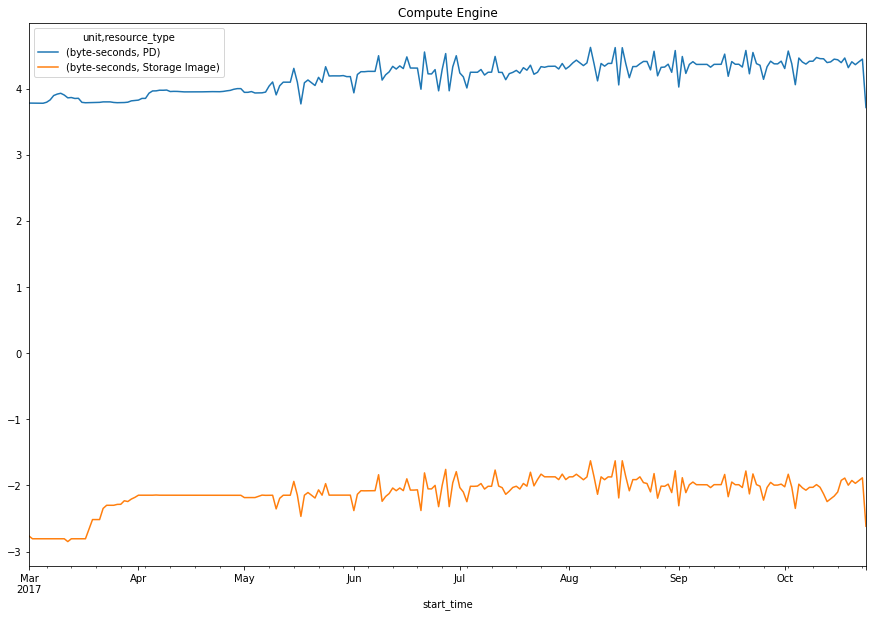

In [50]:
plot_prod("Compute Engine")

Units available:['seconds', 'bytes', 'byte-seconds']
Enter unit: bytes


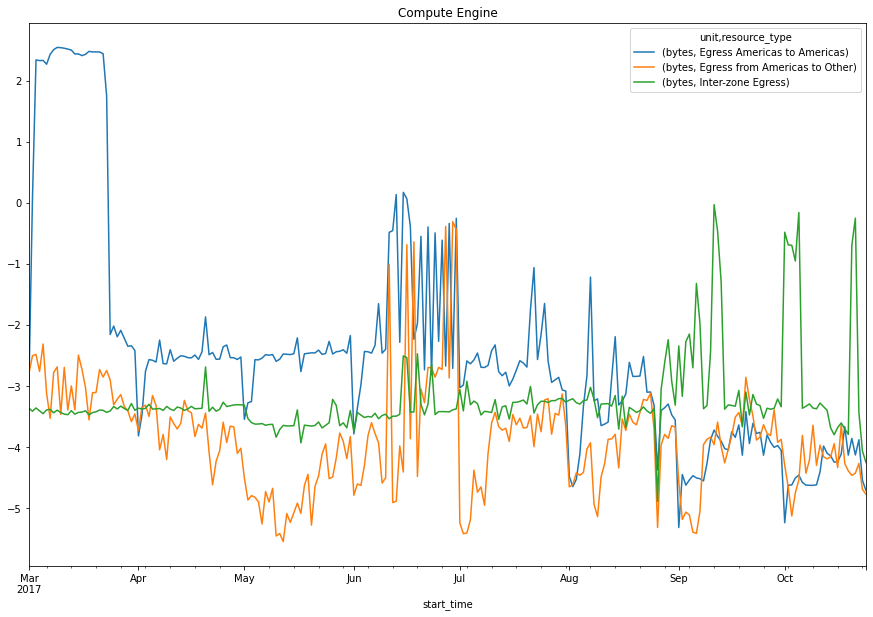

In [51]:
plot_prod("Compute Engine")

In [54]:
! git add .
! git commit -m "adding descriptions Compute"
! git push

The file will have its original line endings in your working directory


[master eaff24f] adding descriptions Compute
 1 file changed, 293 insertions(+), 62 deletions(-)


To https://github.com/jstephenj14/gcp-billing-analysis.git
   2298701..eaff24f  master -> master
